In [1]:
%load_ext autoreload
%aimport os, pandas, numpy, pickle
%autoreload 2

In [2]:
import sys
import os
import pickle
import argparse
import pandas as pd
from sklearn.ensemble.forest import ExtraTreesRegressor

from fqi.et_tuning import run_tuning
from fqi.reward_function import *
from fqi.sars_creator import to_SARS
from fqi.utils import *

from trlib.policies.valuebased import EpsilonGreedy, Softmax
from trlib.policies.qfunction import ZeroQ
from trlib.algorithms.reinforcement.fqi_driver import FQIDriver, DoubleFQIDriver
from trlib.environments.trackEnv import TrackEnv
from trlib.utilities.ActionDispatcher import *

from fqi.fqi_evaluate import run_evaluation

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
simulations = pd.read_csv('./trajectory/dataset_offroad.csv',
                              dtype={'isReference': bool, 'is_partial':bool})

#simulations = simulations[(simulations['NLap'] == 1) | (simulations['NLap'] == 9)]

ref_tr = pd.read_csv('./trajectory/ref_traj.csv')
ref_tr.columns = ['time', 'Acceleration_x', 'Acceleration_y', 'speed_x', 'speed_y',
       'xCarWorld', 'yCarWorld', 'alpha_step']

In [49]:
simulations

,NLap,time,isReference,is_partial,xCarWorld,yCarWorld,nYawBody,nEngine,NGear,prevaSteerWheel,...,speedDifferenceOfModules,actualAccelerationX,actualAccelerationY,referenceAccelerationX,referenceAccelerationY,accelerationDiffX,accelerationDiffY,aSteerWheel,pBrakeF,rThrottlePedal
0,1,0.307996,False,False,654.799744,1169.202148,0.013237,18466.84082,7,-0.001959,...,-2.462826,1.172228,-0.845928,1.300892,0.003601,0.128664,0.849529,-0.001715,0.0,1.0
1,1,0.407996,False,False,663.557922,1169.316528,0.012194,18489.47144,7,-0.001715,...,-2.416658,1.150649,-0.874358,1.277093,0.001861,0.126444,0.876219,-0.001714,0.0,1.0
2,1,0.507996,False,False,672.327209,1169.422852,0.011190,18511.70898,7,-0.001714,...,-2.371231,1.130063,-0.905710,1.252617,-0.000061,0.122554,0.905649,-0.001469,0.0,1.0
3,1,0.607996,False,False,681.107422,1169.519897,0.010168,18533.46802,7,-0.001469,...,-2.326653,1.105262,-0.868164,1.226950,-0.000073,0.121688,0.868091,-0.001469,0.0,1.0
4,1,0.707996,False,False,689.898254,1169.608398,0.009167,18554.90967,7,-0.001469,...,-2.282955,1.080983,-0.905741,1.200744,-0.000058,0.119761,0.905683,-0.001955,0.0,1.0
5,1,0.807996,False,False,698.699524,1169.687988,0.008132,18575.24536,7,-0.001955,...,-2.229615,1.002264,-0.913655,1.175719,0.000528,0.173455,0.914183,-0.001467,0.0,1.0
6,1,0.907996,False,False,707.510803,1169.758301,0.006860,18595.27344,7,-0.001467,...,-2.187247,1.047858,-1.253670,1.159796,0.000023,0.111938,1.253693,-0.002725,0.0,1.0
7,1,1.007996,False,False,716.331848,1169.815918,0.004919,18614.62280,7,-0.002725,...,-2.131727,1.009651,-1.718997,1.122303,0.000020,0.112652,1.719017,-0.003268,0.0,1.0
8,1,1.107996,False,False,725.162415,1169.856689,0.002823,18634.58374,7,-0.003268,...,-2.053136,0.976601,-1.813381,1.112550,0.000780,0.135949,1.814161,-0.003267,0.0,1.0
9,1,1.207996,False,False,734.002502,1169.879517,0.000749,18653.26904,7,-0.003267,...,-2.012541,1.055580,-1.839402,1.078666,0.000126,0.023086,1.839528,-0.003265,0.0,1.0


In [9]:
all_laps = np.unique(simulations.NLap)
lap_times = map(lambda lap: simulations[simulations.NLap == lap]['time'].values[-1], all_laps)
ref_time = ref_tr['time'].values[-1]
perc_deltas = list(map(lambda t: (abs(t - ref_time) / ref_time * 100) <= 1.5, lap_times))
right_laps = all_laps[perc_deltas]
right_laps

array([ 9, 14, 16, 17, 20, 47, 49, 55, 59, 60, 61, 62, 63, 65, 68])

In [ ]:
penalty = LikelihoodPenalty()
penalty.fit(simulations[simulations.NLap.isin(right_laps)][state_cols].values, n_jobs=10)

In [ ]:
file_name = 'penalty.pkl'
with open('./' + file_name, 'wb') as output:
    pickle.dump(penalty, output, pickle.HIGHEST_PROTOCOL)

In [4]:
file_name = 'model_file/penalty/penalty.pkl'
with open('./' + file_name, 'rb') as pol:
     penalty = pickle.load(pol)

In [5]:
rf = Temporal_projection(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))



<IPython.core.display.Javascript object>


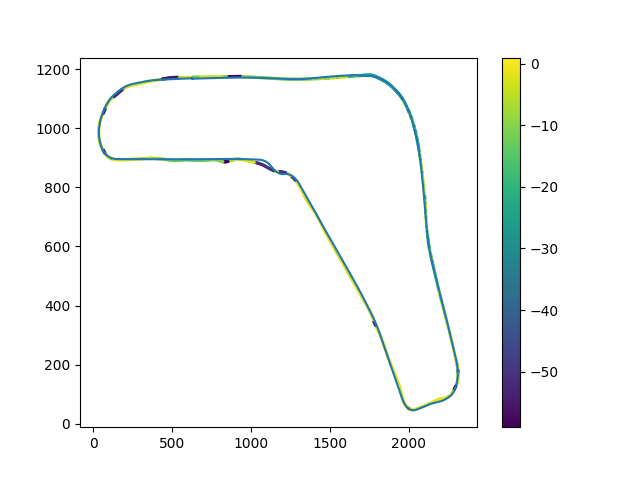

In [6]:
lap = 12
dataset = to_SARS(simulations[simulations.NLap == lap], rf)
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.plot(ref_tr.xCarWorld, ref_tr.yCarWorld)

s = ax.scatter(dataset.xCarWorld, dataset.yCarWorld, c=dataset.r, s=2)
plt.colorbar(s, ax=ax)

In [7]:
dataset = to_SARS(simulations, rf)

In [8]:
nmin = 1
n_jobs =10
# Create environment
state_dim = len(state_cols)
action_dim = len(action_cols)
mdp = TrackEnv(state_dim, action_dim, 0.99999, 'continuous')

# Parameters of ET regressor
regressor_params = {'n_estimators': 100,
                    'criterion': 'mse',
                    'min_samples_split': 2,
                    'min_samples_leaf': nmin,
                    'n_jobs': n_jobs,
                    'random_state': 42}
regressor = ExtraTreesRegressor

In [9]:
#first step
temperature = 0.5  # no exploration
pi = Softmax([], ZeroQ(), temperature)

In [10]:
# Define the order of the columns to pass to the algorithm
cols = ['t'] + state_cols + action_cols + ['r'] + state_prime_cols + ['absorbing']
# Define the masks used by the action dispatcher
state_mask = [i for i, s in enumerate(state_cols) if s in knn_state_cols]
data_mask = [i for i, c in enumerate(cols) if c in knn_state_cols]
action_dispatcher = RadialKDTActionDispatcher
alg_actions = dataset[action_cols].values

In [11]:
fqi = DoubleFQIDriver

In [12]:
max_iterations =100
kdt_norm = False
filt_a_outliers = False
kdt_param = 10
algorithm = fqi(mdp=mdp,
                policy=pi,
                actions=alg_actions,
                max_iterations=max_iterations,
                regressor_type=regressor,
                data=dataset[cols].values,
                action_dispatcher=action_dispatcher,
                state_mask=state_mask,
                data_mask=data_mask,
                s_norm=kdt_norm,
                filter_a_outliers=filt_a_outliers,
                ad_n_jobs=n_jobs,
                ad_param=kdt_param,
                verbose=True,
                **regressor_params)

In [13]:
print('Starting execution')
algorithm.step()

output_path = './model_file/'
reward_function = 'temporal_penalty'
output_name = 'temporal_penalty' + '_reward_model'#reward_function + '_reward_model'#'first_model'
# save algorithm object
algorithm_name = output_name + '.pkl'
with open(output_path + '/' + algorithm_name, 'wb') as output:
    pickle.dump(algorithm, output, pickle.HIGHEST_PROTOCOL)

# save policy object
policy_name = 'policy_' + algorithm_name
with open(output_path + '/' + policy_name, 'wb') as output:
    pickle.dump(algorithm._policy, output, pickle.HIGHEST_PROTOCOL)
print('Saved policy object')

# save action dispatcher object
AD_name = 'AD_' + algorithm_name
with open(output_path + '/' + AD_name, 'wb') as output:
    pickle.dump(algorithm._action_dispatcher, output, pickle.HIGHEST_PROTOCOL)
print('Saved Action Dispatcher')

Starting execution
Step 1
Finding nearest actions for each state prime
Time for action list 7.534217119216919
Time for action set 1.1040782928466797
Time for sprime a mat 18.175575017929077
Iteration 0
fitQ 10.363938570022583
Elapsed time 10.363938570022583
Iteration 1
maxQ 15.920230865478516
fitQ 10.214538335800171
Elapsed time 26.134769201278687
Iteration 2
maxQ 15.631136178970337
fitQ 10.652555465698242
Elapsed time 26.28369164466858
Iteration 3
maxQ 15.327761173248291
fitQ 10.330499410629272
Elapsed time 25.658260583877563
Iteration 4
maxQ 17.19381284713745
fitQ 10.161751985549927
Elapsed time 27.355564832687378
Iteration 5
maxQ 15.55555510520935
fitQ 9.867380857467651
Elapsed time 25.422935962677002
Iteration 6
maxQ 14.967626571655273
fitQ 10.303565740585327
Elapsed time 25.2711923122406
Iteration 7
maxQ 15.321772575378418
fitQ 10.24462890625
Elapsed time 25.566401481628418
Iteration 8
maxQ 14.723123788833618
fitQ 10.72112226486206
Elapsed time 25.44424605369568
Iteration 9
maxQ 1

maxQ 15.975374937057495
fitQ 11.588949918746948
Elapsed time 27.564324855804443
Iteration 89
maxQ 20.15359115600586
fitQ 10.59897756576538
Elapsed time 30.75256872177124
Iteration 90
maxQ 15.85550332069397
fitQ 11.564400911331177
Elapsed time 27.419904232025146
Iteration 91
maxQ 17.171075582504272
fitQ 12.372570276260376
Elapsed time 29.54364585876465
Iteration 92
maxQ 17.450342655181885
fitQ 12.209938049316406
Elapsed time 29.66028070449829
Iteration 93
maxQ 18.131723403930664
fitQ 12.202816247940063
Elapsed time 30.334539651870728
Iteration 94
maxQ 20.31683325767517
fitQ 12.586211442947388
Elapsed time 32.90304470062256
Iteration 95
maxQ 19.797933340072632
fitQ 10.96872878074646
Elapsed time 30.766662120819092
Iteration 96
maxQ 17.814103841781616
fitQ 12.418347597122192
Elapsed time 30.23245143890381
Iteration 97
maxQ 17.902159214019775
fitQ 10.427684545516968
Elapsed time 28.329843759536743
Iteration 98
maxQ 15.888578176498413
fitQ 11.489995241165161
Elapsed time 27.378573417663574
